# **Results Analysis**

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
from models import load_model
from evaluate import predict_targets
from train import train_data_loader, valid_data_loader, test_data_loader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

MPS is available.


In [2]:
# Define seed for re-impelementation

torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    print("CUDA is available.")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    torch.mps.manual_seed(42)
    print("MPS is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

MPS is available.


## **1. Training and Validation Losses and Accuracies**

In [3]:
# Read the train and validation data results 
train_df = pd.read_csv("checkpoints/2023-12-19/13-37/train_results.csv")
valid_df = pd.read_csv("checkpoints/2023-12-19/13-37/valid_results.csv")

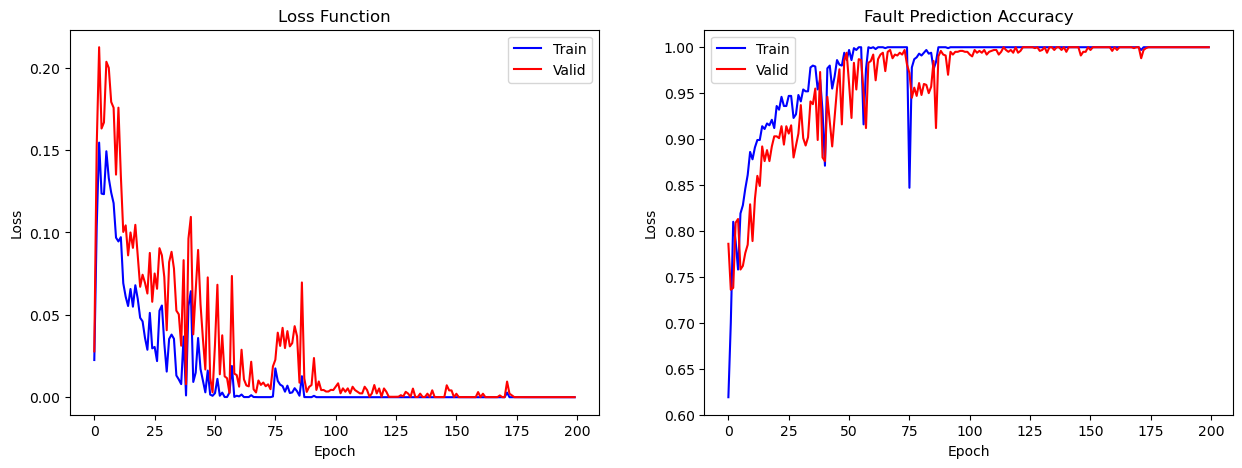

In [4]:
# Visualize the losses and fault prediction accuracies
fig, axis = plt.subplots(1,2, figsize=(15,5))
axis[0].plot(train_df['Loss'], 'b')
axis[0].plot(valid_df['Loss'], 'r')
axis[0].set_title("Loss Function")
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].legend(['Train', 'Valid'])

axis[1].plot(train_df['Fault Class'], 'b')
axis[1].plot(valid_df['Fault Class'], 'r')
axis[1].set_title("Fault Prediction Accuracy")
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Loss")
axis[1].legend(['Train', 'Valid'])

## **2. Confusion Matrix**

In [5]:
# Load the optimized model using the weights 
pred_fault_loc = True
mask_pred_loc = True
model = load_model(d_input_channels=6,
                   pred_fault_loc=pred_fault_loc,
                   mask_pred_loc=mask_pred_loc,
                   device=device,
                   weights_path='checkpoints/2023-12-19/13-37/model_weights.pth'
                   )
model.to(device)

CNN(
  (layers): ModuleList(
    (0): Conv1d(6, 128, kernel_size=(5,), stride=(1,), padding=same)
    (1-2): 2 x Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (3): Conv1d(134, 128, kernel_size=(5,), stride=(1,), padding=same)
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (5): Conv1d(134, 128, kernel_size=(5,), stride=(1,), padding=same)
  )
  (pool): AvgPool1d(kernel_size=(7,), stride=(2,), padding=(3,))
  (class_branch): Linear(in_features=32768, out_features=256, bias=True)
  (class_out): Linear(in_features=256, out_features=1, bias=True)
  (input_branch): Linear(in_features=257, out_features=256, bias=True)
  (branch): Linear(in_features=256, out_features=256, bias=True)
  (loc_out): Linear(in_features=256, out_features=3, bias=True)
)

In [6]:
# Predict the labels for all datasets
train_targets, train_predictions = predict_targets(model, train_data_loader, pred_fault_loc=pred_fault_loc, device=device)
valid_targets, valid_predictions = predict_targets(model, valid_data_loader, pred_fault_loc=pred_fault_loc, device=device)
test_targets, test_predictions = predict_targets(model, test_data_loader, pred_fault_loc=pred_fault_loc, device=device)

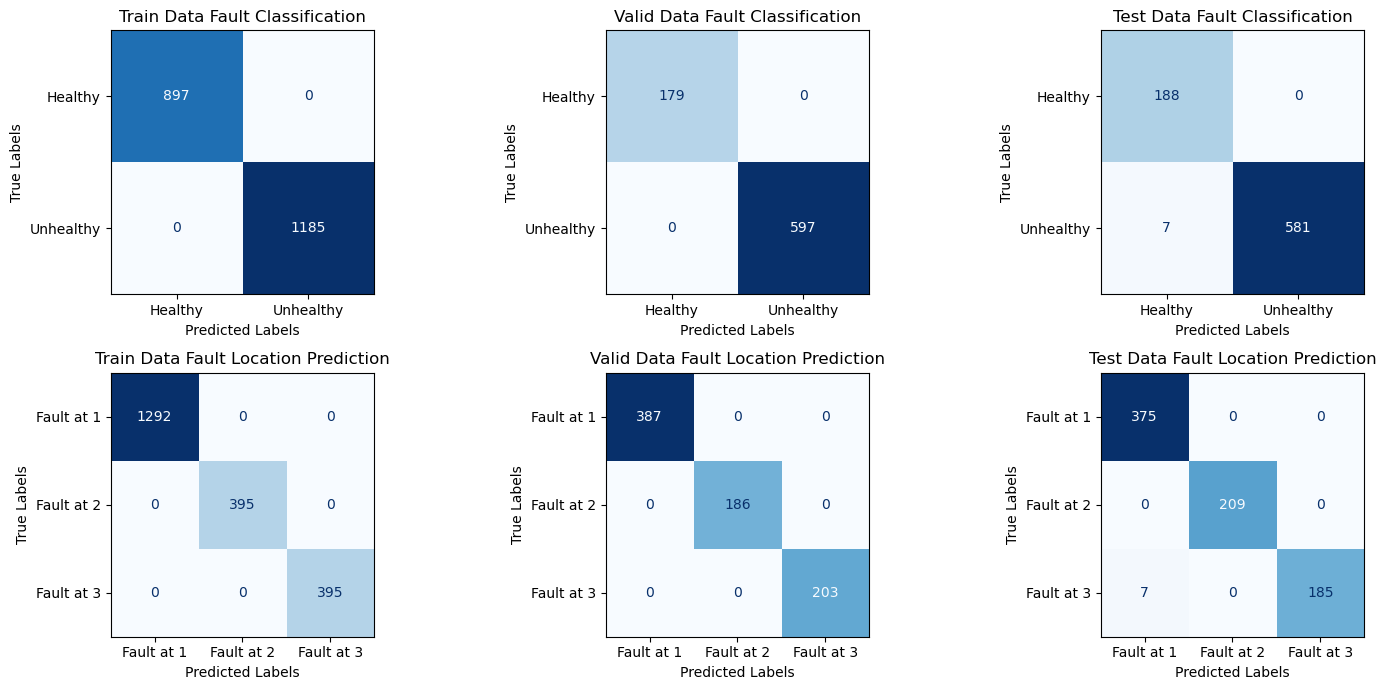

In [7]:
# Plot the confustion matrices for all datasets
fig, axis = plt.subplots(2, 3, figsize=(15, 7))
idxs = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]

class_labels = (
    ['Healthy', 'Unhealthy'],
    ['Healthy', 'Unhealthy'],
    ['Healthy', 'Unhealthy'],
    ['Fault at 1', 'Fault at 2', 'Fault at 3'],
    ['Fault at 1', 'Fault at 2', 'Fault at 3'],
    ['Fault at 1', 'Fault at 2', 'Fault at 3'],
    )
titles = (
    'Train Data Fault Classification',
    'Valid Data Fault Classification',
    'Test Data Fault Classification',
    'Train Data Fault Location Prediction',
    'Valid Data Fault Location Prediction',
    'Test Data Fault Location Prediction',
    )

pred_values = (
    [train_targets[:,0], train_predictions[:,0]],
    [valid_targets[:,0], valid_predictions[:,0]],
    [test_targets[:,0], test_predictions[:,0]],
    [np.argmax(train_targets[:,1:], axis=-1), np.argmax(train_predictions[:,1:], axis=-1)],
    [np.argmax(valid_targets[:,1:], axis=-1), np.argmax(valid_predictions[:,1:], axis=-1)],
    [np.argmax(test_targets[:,1:], axis=-1), np.argmax(test_predictions[:,1:], axis=-1)],
    )

for labels, title, pred, idx in zip(class_labels, titles, pred_values, idxs):
    cm = confusion_matrix(pred[0], pred[1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    i, j = idx
    disp.plot(ax=axis[i,j], cmap=plt.cm.Blues, values_format='d')
    disp.im_.colorbar.remove()
    axis[i,j].set_title(title)
    axis[i,j].set_xlabel('Predicted Labels')
    axis[i,j].set_ylabel('True Labels')

plt.tight_layout()
plt.show()